## Import Libraries

In [38]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform, pdist,jaccard
import sys,  datetime, os
import requests
import time
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from scipy import stats, integrate

In [39]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import PandasTools
from rdkit import RDConfig
from rdkit.Chem import AllChem
from rdkit import Avalon
from rdkit.Chem.AtomPairs import Pairs
from rdkit.Chem.Fingerprints import ClusterMols
from rdkit.Chem.Fingerprints import FingerprintMols

## Load FPS Files

In [65]:
fps = []
files = []

for filename in os.listdir('RDKit_fps/'):
    fps.append(filename[:-24])
    df = pd.read_table('RDKit_fps/'+ filename)
    df[df.columns[0]] = df[df.columns[0]].astype(str)
    files.append(df.set_index(df.columns[0]))

fpsfiles_dict=dict(zip(fps, files)) 
del fpsfiles_dict['']
fps.remove('')

In [66]:
names = []
files = []

for filename in os.listdir('All_bmat/'):
    names.append(filename[:-12])
    df = pd.read_table('All_bmat/'+ filename)
    files.append(df.set_index(df.columns[0]))

namefiles_dict=dict(zip(names, files))   

## Build Similarity Matrix

In [67]:
def pairwise_dis(df, metric):
    array_matrix = metrics.pairwise_distances(df, metric = metric)
    return array_matrix

def vector(array_matrix):
    return squareform(array_matrix)

In [68]:
fps_pheno_df = pd.DataFrame(0, index = names + fps, columns = names + fps)
fps_pheno_df.head()

,DrugBank_Targets,PharmagKB_SE,TTD_Indications,Sider_Indications,ChEMBL_MOA,DrugIndicationDB_Indications,DrugCentral_Targets,DrugGeneInteract_Targets,DrugRepurposing_Targets,DrugRepurposing_MOA,...,Avalon,Morg1f,RDKfps,Morg1,Morg2,Topological,TopologicalTorsion,MACCs,Morg2f,AtomPair
DrugBank_Targets,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PharmagKB_SE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTD_Indications,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sider_Indications,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ChEMBL_MOA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
for dbname1 in names:
    for dbname2 in names:
        if fps_pheno_df.loc[dbname1, dbname2] != 0:
            continue
        db1, db2 = namefiles_dict[dbname1].T, namefiles_dict[dbname2].T
        shared = sorted(list(set(db1.index) & set(db2.index)))
        db1 = db1.loc[shared]
        db2 = db2.loc[shared]
        db1_vect = vector(pairwise_dis(db1, 'manhattan'))
        db2_vect = vector(pairwise_dis(db2, 'manhattan'))
        p_coeff = pearsonr(db1_vect, db2_vect)[0]
        fps_pheno_df.loc[dbname1, dbname2] = p_coeff

In [70]:
for fps1 in fps:
    for fps2 in fps:
        if fps_pheno_df.loc[fps1, fps2] != 0:
            continue
        fpdb1, fpdb2 = fpsfiles_dict[fps1], fpsfiles_dict[fps2]
        shared = sorted(list(set(fpdb1.index) & set(fpdb2.index)))
        fpdb1 = fpdb1.loc[shared]
        fpdb2 = fpdb2.loc[shared]
        fpdb1_vect = vector(pairwise_dis(fpdb1, 'manhattan'))
        fpdb2_vect = vector(pairwise_dis(fpdb2, 'manhattan'))
        p_coeff = pearsonr(fpdb1_vect, fpdb2_vect)[0]
        fps_pheno_df.loc[fps1, fps2] = p_coeff
        fps_pheno_df.loc[fps2, fps1] = p_coeff

In [72]:
for dbname in names:
    for fp in fps:
        if fps_pheno_df.loc[dbname, fp] != 0:
            continue
        db= namefiles_dict[dbname].T
        fpdb = fpsfiles_dict[fp]
        shared = sorted(list(set(db.index) & set(fpdb.index)))
        db = db.loc[shared]
        fpdb = fpdb.loc[shared]
        db_vect = vector(pairwise_dis(db, 'manhattan'))
        fpdb_vect = vector(pairwise_dis(fpdb, 'manhattan'))
        p_coeff = pearsonr(db_vect, fpdb_vect)[0]
        fps_pheno_df.loc[dbname, fp] = p_coeff
        fps_pheno_df.loc[fp, dbname] = p_coeff

In [85]:
fps_pheno_df.head(2)

,DrugBank_Targets,PharmagKB_SE,TTD_Indications,Sider_Indications,ChEMBL_MOA,DrugIndicationDB_Indications,DrugCentral_Targets,DrugGeneInteract_Targets,DrugRepurposing_Targets,DrugRepurposing_MOA,...,Avalon,Morg1f,RDKfps,Morg1,Morg2,Topological,TopologicalTorsion,MACCs,Morg2f,AtomPair
DrugBank_Targets,1.000000,0.091691,0.014343,0.105706,0.251992,0.244065,0.289408,0.366812,0.783047,0.222933,...,-0.002912,-0.069614,-0.019863,-0.077720,-0.076709,0.000284,-0.062820,0.023734,-0.090059,-0.086826
PharmagKB_SE,0.091691,1.000000,-0.049658,0.220222,-0.005490,0.338174,0.064122,0.315889,0.035058,0.049764,...,0.055523,0.039602,0.036944,0.081983,0.069918,0.028515,0.035677,0.044577,0.050491,0.029846


## Plots for full df

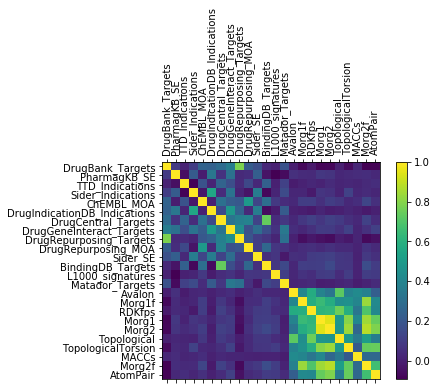

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(fps_pheno_df)
fig.colorbar(cax)

plt.xticks(range(len(names + fps)),names+fps, rotation = 90)
plt.yticks(range(len(names + fps)),names+fps)
plt.show()

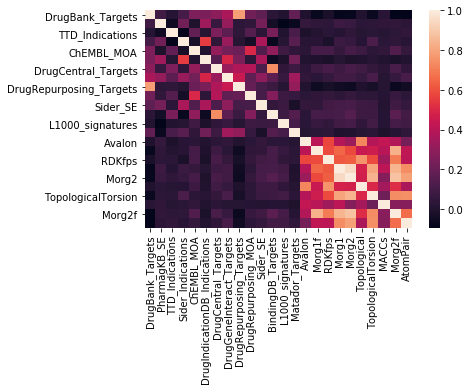

In [75]:
sns.heatmap(fps_pheno_df)

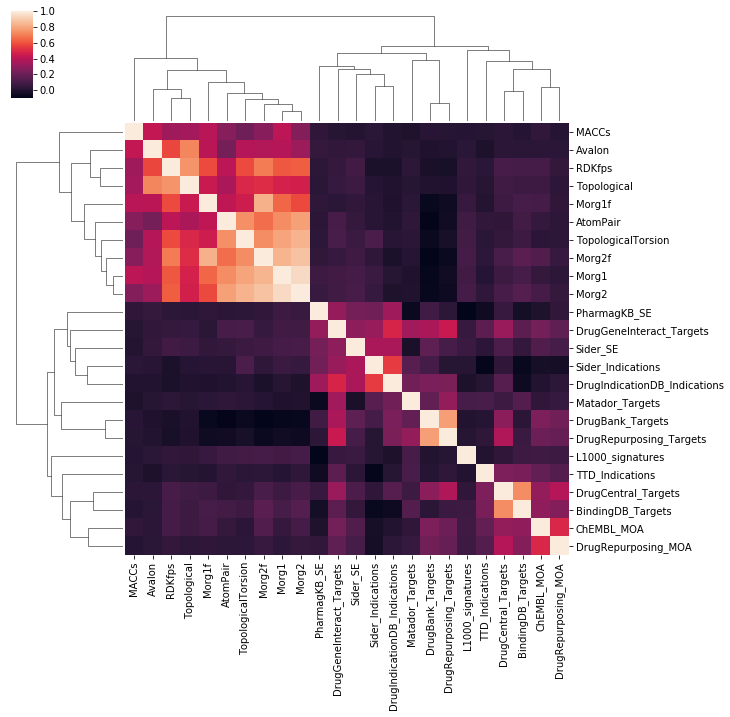

In [76]:
sns.clustermap(fps_pheno_df)

## Plots for only cross df

In [81]:
fps_pheno_cross_df = fps_pheno_df.loc['DrugBank_Targets':'Matador_Targets', 'Avalon':'AtomPair']

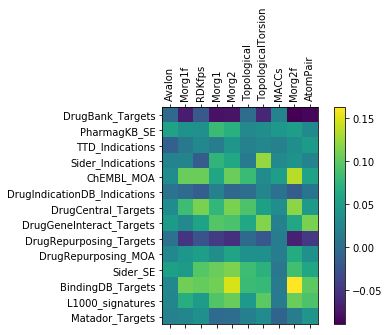

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(fps_pheno_cross_df)
fig.colorbar(cax)

plt.xticks(range(len(fps)),fps, rotation = 90)
plt.yticks(range(len(names)),names)
plt.show()

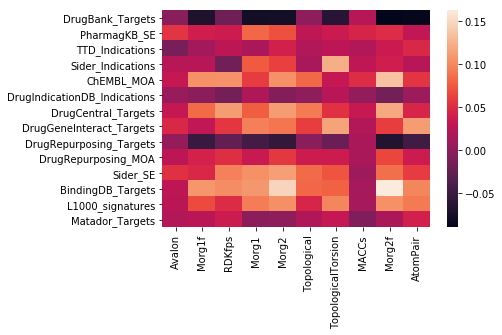

In [83]:
sns.heatmap(fps_pheno_cross_df)

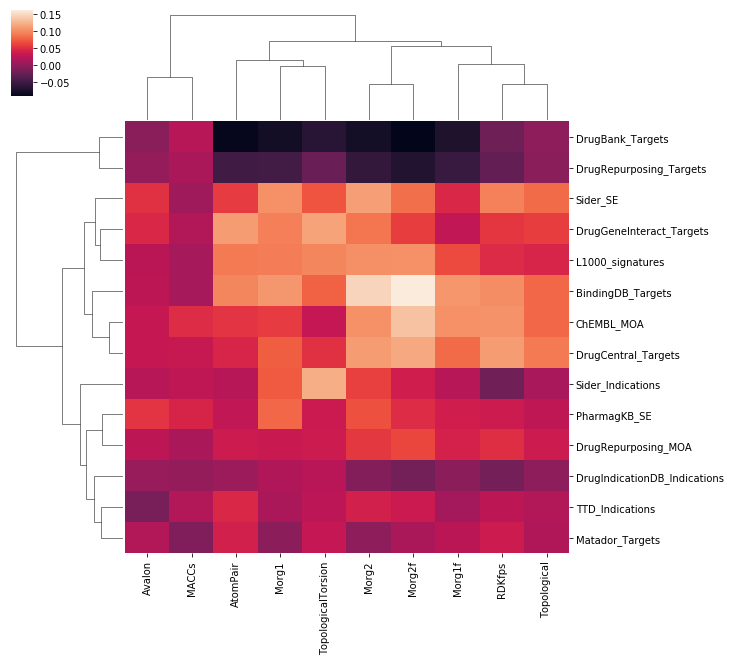

In [84]:
sns.clustermap(fps_pheno_cross_df)